In [1]:
## Definition of the DrugSDA SCP server, including basic operations such as connect, disconnect, list_tools, and parse_result.
import asyncio
import json
from mcp.client.streamable_http import streamablehttp_client
from mcp import ClientSession

DrugSDA_Model_SERVER_URL = "https://scp.intern-ai.org.cn/api/v1/mcp/3/DrugSDA-Model"    ## DrugSDA-Model Server
DrugSDA_Tool_SERVER_URL = "https://scp.intern-ai.org.cn/api/v1/mcp/2/DrugSDA-Tool"      ## DrugSDA-Tool Server

class DrugSDAClient:    
    def __init__(self, server_url: str):
        self.server_url = server_url
        self.session = None
        
    async def connect(self):
        print(f"server url: {self.server_url}")
        try:
            self.transport = streamablehttp_client(
                url=self.server_url,
                headers={"SCP-HUB-API-KEY": "sk-a0033dde-b3cd-413b-adbe-980bc78d6126"}
            )
            self.read, self.write, self.get_session_id = await self.transport.__aenter__()
            
            self.session_ctx = ClientSession(self.read, self.write)
            self.session = await self.session_ctx.__aenter__()

            await self.session.initialize()
            session_id = self.get_session_id()
            
            print(f"✓ connect success")
            return True
            
        except Exception as e:
            print(f"✗ connect failure: {e}")
            import traceback
            traceback.print_exc()
            return False
    
    async def disconnect(self):
        try:
            if self.session:
                await self.session_ctx.__aexit__(None, None, None)
            if hasattr(self, 'transport'):
                await self.transport.__aexit__(None, None, None)
            print("✓ already disconnected\n")
        except Exception as e:
            print(f"✗ disconnect error: {e}")
    
    async def list_tools(self):        
        try:
            tools_list = await self.session.list_tools()
            print(f"tool count: {len(tools_list.tools)}:\n")
            
            for i, tool in enumerate(tools_list.tools, 1):
                print(f"{i:2d}. {tool.name}")
                if tool.description:
                    desc_line = tool.description.split('\n')[0]
                    print(f"    {desc_line}")
            
            print(f"✓ Get tool list success\n")
            return tools_list.tools
            
        except Exception as e:
            print(f"✗ Get tool list fail: {e}")
            return []
    
    def parse_result(self, result):
        try:
            if hasattr(result, 'content') and result.content:
                content = result.content[0]
                if hasattr(content, 'text'):
                    return json.loads(content.text)
            return str(result)
        except Exception as e:
            return {"error": f"parse error: {e}", "raw": str(result)}

In [ ]:
'''
Example 1: Virtual Screening of Drug-like Molecules.
(a) Given a list of candidate molecules in SMILES format (smiles_list), the drug-likeness (QED) and toxicity (LD50) scores are first calculated. Molecules that clearly fail to meet predefined thresholds are filtered out. 
(b) The remaining candidates then undergo docking against a target protein—a multi-step process involving protein structure retrieval, structural preprocessing, binding pocket identification, file format conversion, and finally, quick molecular docking. 
(c) Compounds with a binding affinity lower than −7.0 kcal/mol are selected as high-potential candidates.
'''
async def main():
    tool_client = DrugSDAClient(DrugSDA_Tool_SERVER_URL)
    if not await tool_client.connect():
        print("connection failed")
        return
    
    model_client = DrugSDAClient(DrugSDA_Model_SERVER_URL)
    if not await model_client.connect():
        print("connection failed")
        return
    
    smiles_list = ['O=C(Nc1cccc2c1CCCC2)N1CCc2c([nH]c3ccccc23)C1c1cccc(F)c1F',
        'O=C(Nc1cccc(C2CN3CCSC3c3ccccc32)c1)Nc1ccc2ccccc2c1',
        'Cc1ccccc1N1CCN(C2=Nc3cc(Cl)ccc3Nc3ccc(F)cc32)CC1',
        'O=C1NCc2ccc(cc2)Cc2cccc(c2)CNC(=O)c2coc(n2)-c2cccc(c2)-c2cccc(c2)-c2cccc(c2)-c2cccc(c2)COc2cccc1c2',
        'O=C(Nc1ccc2c(c1)C(F)(F)C(F)(F)CC2)N1CCc2ccccc2C1c1c[nH]c2ccccc12',
        'O=C(c1cccc(F)c1F)N1CCc2c(c3ccccc3n2Cc2cccc(C=Cc3ccc4cc(F)ccc4n3)c2)C1',
        'O=C(CN(C(=O)c1cccc(F)c1)N1C(=O)C2C3c4ccccc4C(c4ccccc43)C2C1=O)c1ccccc1',
        'O=C(Nc1cccc2c1CCCC2)N1CCc2c([nH]c3ccccc23)C1c1ccc(F)cc1',
        'O=C(c1ccc2c(c1)N(Cc1ccccc1)C(=O)c1ccccc1S2(=O)=O)c1ccc2ccccc2c1',
        'O=C(Nc1cccc(-c2cccc(C(F)(F)F)c2)c1)c1cccc(-c2ccc3ccccc3c2)c1',
        'O=C(Nc1ccc2c(c1)C(F)(F)C(F)(F)CC2)N1CCc2ccccc2C1C1CCCCC1',
        'O=C(c1ccccc1F)N1CCN2C(=O)c3ccccc3C12c1ccc(Cl)cc1',
        'CCc1ccc(C2c3[nH]c4ccccc4c3CCN2C(=O)CN2C(=O)c3ccccc3C2=O)cc1',
        'O=C(Nc1ccc(F)c(C(F)(F)F)c1)Nc1cccc2ccc(Nc3cccc(-c4ccccc4)c3)nc12',
        'O=C(Nc1cccc(Oc2ccccc2)c1)Nc1cccc(-c2cccc(-c3nc4cc(C(F)(F)F)ccc4[nH]3)c2)c1',
        'O=C(c1cccc(-c2cccc(C(F)(F)F)c2)c1)N1CCc2c(-c3cccc(F)c3)ccnc2C1',
        'O=C(c1ccc2c(c1)C(F)(F)C(c1ccccc1)C2c1ccc(Cl)cc1)N1CCOCC1',
        'O=C(Nc1ccc2c(c1)C(F)(F)C(F)(F)CC2)N1CCc2ccccc2C1c1ccc(F)cc1F',
        'O=C(C1CC1c1cccc(F)c1)N1CCN(C2c3ccccc3-c3ccccc32)CC1',
        'CNc1ccc2c(c1)NC1(CCN(C(=O)c3ccc4[nH]ccc4c3)CC1)c1ccccc1C2',
        'O=C1c2cccc3cccc(c23)C1c1cccc(Oc2ccccc2)c1',
        'O=C(c1ccccc1)N1CCN(C(=O)c2cc(Cc3n[nH]c(=O)c4ccccc34)ccc2F)CC1',
        'CC(=O)Nc1cccc(Nc2c3ccccc3nc3ccccc23)c1',
        'O=C(Nc1cccc(-c2cccc(-c3nc4cc(C(F)(F)F)ccc4[nH]3)c2)c1)Nc1cccc2c1CCCC2',
        'O=C(Nc1ccc2c(c1)N(S(=O)(=O)c1cccs1)CCC2)N1CC2CC(C1)c1cccc(=O)n1C2',
        'O=C(NC1CCCC1)C1Cc2ccccc2CN1C(=O)c1cccc2ccccc12',
        'O=C(Nc1ccccc1)c1cccc(Nc2ccc3c(c2)OCc2ccccc2C3=O)c1',
        'Cc1cc(C)cc(NC(=O)N2CCc3c([nH]c4ccccc34)C2c2ccccc2F)c1',
        'O=C(Nc1ccc2c(c1)C(F)(F)C(F)(F)CC2)c1ccc2c(c1)C(=O)N(Cc1ccccc1)C2=O',
        'O=C(c1cccc(-c2cccc(CN3CCN(c4ccccc4)CC3)c2)c1)N1CCC(O)CC1',
        'CC1(C)N=C(N)N=C(N)N1c1ccc(C(=O)C(c2ccc(N3C(N)=NC(N)=NC3(C)C)cc2)c2ccc(C(F)(F)F)cc2)cc1',
        'O=C1c2ccccc2C(=O)c2c1ccc1c2C(c2ccccc2)(c2ccccc2)OC1',
        'CC(C)(C)c1ccc(C(=O)Nc2cccc(Nc3ccc4c(c3)OCc3ccccc3C4=O)c2)cc1',
        'O=C(c1cccc(Cc2nnc(O)c3c2CCCC3)c1)N1CCN(C(=O)c2ccco2)CC1',
        'O=C1CC(c2ccccc2)c2c(c3ccccc3c3ccccc23)N1',
        'Cc1cccc(C2C3=C(COC3=O)Nc3ccc4ccccc4c32)c1',
        'Cc1ccc2c(c1)C(=Nc1cccc(-c3ccc(N4CCOCC4)cc3)c1)c1ccccc1-2',
        'O=C(c1cccc(Cc2ccc(F)cc2)c1)N1CCN(C(=O)c2ccc3ccccc3c2)CC1',
        'COc1cccc(C23c4ccccc4C(=O)N2CCN3C(=O)c2cc(F)c(F)c(F)c2)c1',
        'O=C(c1ccc(F)cc1F)N1CCN2C(=O)c3ccccc3C12c1ccc(Cl)cc1',
        'O=C(c1cccc(F)c1)N1CCN2C(=O)c3ccccc3C12c1ccc(Cl)cc1',
        'O=C1C2Cc3c([nH]c4ccccc34)C(c3ccc4c(c3)OCO4)N2C(=O)CN1c1ccc(F)cc1',
        'O=C(Nc1cccc(-c2cccc(-c3nc4cc(C(F)(F)F)ccc4[nH]3)c2)c1)Nc1ccc2c(c1)CCC2',
        'O=C(Nc1cccc(Oc2ccc3ccccc3c2)c1)c1cccc(-c2ccc3ccccc3c2)c1',
        'O=C(c1ccc(-c2cccc(F)c2)cc1)N1CCc2c([nH]c3ccccc23)C1c1ccc2c(c1)OCO2',
        'O=C(Nc1cccc2c1CCCC2)N1CCc2c([nH]c3ccccc23)C1c1ccc(Cl)cc1',
        'O=C(Nc1ccc2c(c1)C(F)(F)C(F)(F)CC2)N1CCc2ccccc2C1c1ccc(C(F)(F)F)cc1',
        'O=C(Nc1cccc(-c2cccc(-c3nc4cc(C(F)(F)F)ccc4[nH]3)c2)c1)Nc1cccc2ccccc12',
        'O=C(Nc1cccc(F)c1)N1CCc2c([nH]c3ccccc23)C1c1ccccc1F',
        'O=C(NCc1cccc(-c2cccc(-c3cc4c[nH]ccc-4n3)c2O)c1)Nc1ccc(F)cc1']

    ## step 1. calculate QED scores, call SCP tool calculate_mol_drug_chemistry
    result = await tool_client.session.call_tool(
        "calculate_mol_drug_chemistry",
        arguments={
            "smiles_list": smiles_list
        }
    )
    result_data = tool_client.parse_result(result)
    QED_result = result_data["metrics"]
    print ("Compute QED score finish ...")
    
    ## step 2. Calculate LD50 scores, call SCP tool pred_molecule_admet
    result = await model_client.session.call_tool(
        "pred_molecule_admet",
        arguments={
            "smiles_list": smiles_list
        }
    )
    result_data = model_client.parse_result(result)
    LD50_result = result_data["admet_preds"]
    print ("Predict admet finish ...")
    
    ## step 3. Filter molecules with QED ≥ 0.6 and LD50_Zhu ≥ 3.0
    select_smiles_list = []
    for i in range(len(smiles_list)):
        smiles = smiles_list[i]
        QED = QED_result[i]["qed"]
        LD50 = LD50_result[i]["LD50_Zhu"]
        if QED >= 0.6 and LD50 >= 3.0:
            select_smiles_list.append(smiles)
            
    print (len(select_smiles_list), select_smiles_list[0])
    
    ## step 4. Retrieve and download the target protein structure, call SCP tool retrieve_protein_data_by_pdbcode.
    pdb_code = "6vkv"
    result = await tool_client.session.call_tool(
        "retrieve_protein_data_by_pdbcode",
        arguments={
            "pdb_code": pdb_code
        }
    )

    result_data = tool_client.parse_result(result)
    pdb_path = result_data["pdb_path"]
    print ("download protein structure: ", pdb_path)
    
    ## step 5. Extract main chain, call SCP tool save_main_chain_pdb
    result = await tool_client.session.call_tool(
        "save_main_chain_pdb",
        arguments={
            "pdb_file_path": pdb_path,
            "main_chain_id": ""
        }
    )
    
    result_data = tool_client.parse_result(result)
    pdb_path = result_data["out_file"]
    print ("extract protein chain: ", pdb_path)
    
    ## step 6. Fix PDB, call SCP tool fix_pdb_dock
    result = await tool_client.session.call_tool(
        "fix_pdb_dock",
        arguments={
            "pdb_file_path": pdb_path
        }
    )
    
    result_data = tool_client.parse_result(result)
    pdb_path = result_data["fix_pdb_file_path"]
    print ("fix protein pdb: ", pdb_path)
    
    ## step 7. Identify binding pockets, call SCP tool run_fpocket
    result = await model_client.session.call_tool(
        "run_fpocket",
        arguments={
            "pdb_file_path": pdb_path
        }
    )
    
    result_data = model_client.parse_result(result)
    best_pocket = result_data["pockets"][0]
    print ('pocket info: ', best_pocket)
    
    ## step 8. Convert SMILES to PDBQT format, call SCP tool convert_smiles_to_format
    result = await tool_client.session.call_tool(
        "convert_smiles_to_format",
        arguments={
            "inputs": select_smiles_list,
            "target_format": "pdbqt"
        }
    )
    result_data = tool_client.parse_result(result)
    ligand_paths = [x["output_file"] for x in result_data["convert_results"]]
    print (ligand_paths)
    
    ## step 9. Convert receptor PDB to PDBQT format, call SCP tool convert_pdb_to_pdbqt_dock
    result = await tool_client.session.call_tool(
        "convert_pdb_to_pdbqt_dock",
        arguments={
            "pdb_file_path": pdb_path
        }
    )
    result_data = tool_client.parse_result(result)
    receptor_path = result_data["output_file"]
    print (receptor_path)
    
    ## step 10. Molecular docking, call SCP tool quick_molecule_docking
    result = await model_client.session.call_tool(
        "quick_molecule_docking",
        arguments={
            "receptor_path": receptor_path,
            "ligand_paths": ligand_paths,
            "center_x": best_pocket["center_x"],
            "center_y": best_pocket["center_y"],
            "center_z": best_pocket["center_z"],
            "size_x": best_pocket["size_x"],
            "size_y": best_pocket["size_y"],
            "size_z": best_pocket["size_z"]
        }
    )
    result_data = model_client.parse_result(result)
    print ("docking finish ...")
    
    ## step 11. Select final candidate molecules with binding affinity ≤ −7.0 kcal/mol
    final_smiles_list = []
    index = 0
    for item in result_data["docking_results"]:
        affinity = item['affinity']
        if affinity <= -7.0:
            final_smiles_list.append(select_smiles_list[index])
        index += 1
    
    print (final_smiles_list)
    
    await model_client.disconnect()
    await tool_client.disconnect()
    

if __name__ == '__main__':
    await main()

server url: https://scp.intern-ai.org.cn/api/v1/mcp/2/DrugSDA-Tool
✓ connect success
server url: https://scp.intern-ai.org.cn/api/v1/mcp/3/DrugSDA-Model
✓ connect success
Compute QED score finish ...
Predict admet finish ...
6 O=C(c1ccccc1F)N1CCN2C(=O)c3ccccc3C12c1ccc(Cl)cc1
download protein structure:  /root/lwj/wll/code/DrugAgentTools/exp_data/6vkv.pdb
extract protein chain:  /root/lwj/wll/code/DrugAgentTools/exp_data/6vkv_chainA.pdb
fix protein pdb:  /root/lwj/wll/code/DrugAgentTools/exp_data/6vkv_chainA_fix.pdb
pocket info:  {'pocket_id': 1, 'score': 0.373, 'center_x': 2.0607, 'center_y': -59.641, 'center_z': -4.5997, 'size_x': 15.3007, 'size_y': 25.5419, 'size_z': 17.1074, 'n_atoms': 47}
['/root/lwj/wll/code/DrugAgentTools/exp_data/smiles_0.pdbqt', '/root/lwj/wll/code/DrugAgentTools/exp_data/smiles_1.pdbqt', '/root/lwj/wll/code/DrugAgentTools/exp_data/smiles_2.pdbqt', '/root/lwj/wll/code/DrugAgentTools/exp_data/smiles_3.pdbqt', '/root/lwj/wll/code/DrugAgentTools/exp_data/smiles_4.

In [3]:
## Example 2. Drug molecule-mediated reversal of disease state prediction

async def main():
    tool_client = DrugSDAClient(DrugSDA_Tool_SERVER_URL)
    if not await tool_client.connect():
        print("connection failed")
        return
    
    model_client = DrugSDAClient(DrugSDA_Model_SERVER_URL)
    if not await model_client.connect():
        print("connection failed")
        return
    
    ## step 1. Validate SMILES, call SCP tool is_valid_smiles
    smiles_list = ['Nc1nnc(S(=O)(=O)NCCc2ccc(O)cc2)s1', 
        'COc1ccc2c(=O)cc(C(=O)N3CCN(c4ccc(F)cc4)CC3)oc2c1',
        'CCCC1CCC(CC(=O)Cl)(C2CCCCC2)CC1',
        'O=C1CC(N(CCC2=CCCCC2)C(=O)Cc2ccc(Cl)cc2)C(=O)N1c1ccc(Br)cc1',
        'CCCCCc1ccc(C=Cc2ccccc2)cc1',
        'ABCCOOO']

    result = await tool_client.session.call_tool(
        "is_valid_smiles",
        arguments={
            "smiles_list": smiles_list
        }
    )

    result_data = tool_client.parse_result(result)
    valid_smiles_list = [x['smiles'] for x in result_data['valid_res'] if x['is_valid'] is True]
    print (valid_smiles_list)

    ## step 2. Calculate disease reversal scores, call SCP tool calculate_dleps_score
    result = await model_client.session.call_tool(
        "calculate_dleps_score",
        arguments={
            "smiles_list": valid_smiles_list,
            "disease_name": "Aging"
        }
    )
    
    result_data = model_client.parse_result(result)
    for item in result_data['pred_scores']:
        print (item)
    
    await model_client.disconnect()
    await tool_client.disconnect()
    
if __name__ == '__main__':
    await main()


server url: https://scp.intern-ai.org.cn/api/v1/mcp/2/DrugSDA-Tool
✓ connect success
server url: https://scp.intern-ai.org.cn/api/v1/mcp/3/DrugSDA-Model
✓ connect success
['Nc1nnc(S(=O)(=O)NCCc2ccc(O)cc2)s1', 'COc1ccc2c(=O)cc(C(=O)N3CCN(c4ccc(F)cc4)CC3)oc2c1', 'CCCC1CCC(CC(=O)Cl)(C2CCCCC2)CC1', 'O=C1CC(N(CCC2=CCCCC2)C(=O)Cc2ccc(Cl)cc2)C(=O)N1c1ccc(Br)cc1', 'CCCCCc1ccc(C=Cc2ccccc2)cc1']
{'smiles': 'Nc1nnc(S(=O)(=O)NCCc2ccc(O)cc2)s1', 'cs_score': 0.0}
{'smiles': 'COc1ccc2c(=O)cc(C(=O)N3CCN(c4ccc(F)cc4)CC3)oc2c1', 'cs_score': 0.23086356041942557}
{'smiles': 'CCCC1CCC(CC(=O)Cl)(C2CCCCC2)CC1', 'cs_score': 0.0}
{'smiles': 'O=C1CC(N(CCC2=CCCCC2)C(=O)Cc2ccc(Cl)cc2)C(=O)N1c1ccc(Br)cc1', 'cs_score': 0.0}
{'smiles': 'CCCCCc1ccc(C=Cc2ccccc2)cc1', 'cs_score': 0.2524134198180845}
✓ already disconnected

✓ already disconnected



In [4]:
## Example 3. Molecular property analysis

from collections import defaultdict

def merge_lists_by_smiles(*lists):
    merged = defaultdict(dict)

    for lst in lists:
        for d in lst:
            smiles = d['smiles']
            merged[smiles].update(d)

    return list(merged.values())

async def main():
    client = DrugSDAClient(DrugSDA_Tool_SERVER_URL)
    if not await client.connect():
        print("connection failed")
        return
    
    ## step 1. Calculate basic molecular metrics, call SCP tool calculate_mol_basic_info
    smiles_list = ['Nc1nnc(S(=O)(=O)NCCc2ccc(O)cc2)s1', 
        'COc1ccc2c(=O)cc(C(=O)N3CCN(c4ccc(F)cc4)CC3)oc2c1',
        'CCCC1CCC(CC(=O)Cl)(C2CCCCC2)CC1',
        'O=C1CC(N(CCC2=CCCCC2)C(=O)Cc2ccc(Cl)cc2)C(=O)N1c1ccc(Br)cc1',
        'CCCCCc1ccc(C=Cc2ccccc2)cc1']

    result = await client.session.call_tool(
        "calculate_mol_basic_info",
        arguments={
            "smiles_list": smiles_list
        }
    )

    result_data = client.parse_result(result)
    # print (result_data['metrics'])
    basic_metrics = result_data['metrics']
    
    ## step 2. Calculate hydrophobicity-related molecular descriptors, call SCP tool calculate_mol_hydrophobicity
    result = await client.session.call_tool(
        "calculate_mol_hydrophobicity",
        arguments={
            "smiles_list": smiles_list
        }
    )

    result_data = client.parse_result(result)
    hydrophobicity_metrics = result_data['metrics']
    # print (hydrophobicity_metrics)
    
    ## step 3. Calculate hydrogen bond-related molecular descriptors, call SCP tool calculate_mol_hbond
    result = await client.session.call_tool(
        "calculate_mol_hbond",
        arguments={
            "smiles_list": smiles_list
        }
    )

    result_data = client.parse_result(result)
    hbond_metrics = result_data['metrics']

    ## step 4. Calculate molecular structure complexity, call SCP tool calculate_mol_structure_complexity
    result = await client.session.call_tool(
        "calculate_mol_structure_complexity",
        arguments={
            "smiles_list": smiles_list
        }
    )

    result_data = client.parse_result(result)
    structure_metrics = result_data['metrics']
    # print (structure_metrics)

    ## step 5. Calculate molecular topology descriptors, call SCP tool calculate_mol_topology
    result = await client.session.call_tool(
        "calculate_mol_topology",
        arguments={
            "smiles_list": smiles_list
        }
    )

    result_data = client.parse_result(result)
    topology_metrics = result_data['metrics']
    
    ## step 6. Calculate molecular chemistry descriptors, call SCP tool calculate_mol_drug_chemistry
    result = await client.session.call_tool(
        "calculate_mol_drug_chemistry",
        arguments={
            "smiles_list": smiles_list
        }
    )

    result_data = client.parse_result(result)
    chemistry_metrics = result_data['metrics']
    
    ## step 7. Calculate molecular charge descriptors, call SCP tool calculate_mol_charge
    result = await client.session.call_tool(
        "calculate_mol_charge",
        arguments={
            "smiles_list": smiles_list
        }
    )

    result_data = client.parse_result(result)
    charge_metrics = result_data['metrics']
    
    ## step 8. Calculate molecular complexity descriptors, call SCP tool calculate_mol_complexity
    result = await client.session.call_tool(
        "calculate_mol_complexity",
        arguments={
            "smiles_list": smiles_list
        }
    )

    result_data = client.parse_result(result)
    complexity_metrics = result_data['metrics']
    
    result = merge_lists_by_smiles(basic_metrics, hydrophobicity_metrics, hbond_metrics, structure_metrics, topology_metrics, chemistry_metrics, charge_metrics, complexity_metrics)
    for r in result:
        print(r)
    
    await client.disconnect()
    
if __name__ == '__main__':
    await main()

server url: https://scp.intern-ai.org.cn/api/v1/mcp/2/DrugSDA-Tool
✓ connect success
{'smiles': 'Nc1nnc(S(=O)(=O)NCCc2ccc(O)cc2)s1', 'molecular_formula': 'C10H12N4O3S2', 'molecular_weight': 300.365, 'num_heavy_atoms': 19, 'num_atoms': 19, 'num_bonds': 20, 'num_valence_electrons': 102, 'formal_charge': 0, 'logp': 0.3469, 'molar_refractivity': 71.3207, 'num_h_donors': 3, 'num_h_acceptors': 7, 'num_rotatable_bonds': 5, 'num_rings': 2, 'num_aromatic_rings': 2, 'num_aliphatic_rings': 0, 'num_saturated_rings': 0, 'num_heteroatoms': 9, 'fraction_csp3': 0.2, 'num_bridgehead_atoms': 0, 'tpsa': 118.2, 'chi0v': 11.4086, 'chi1v': 7.6375, 'chi2v': 6.6702, 'chi3v': 4.875, 'chi4v': 3.2396, 'chi0n': 9.7756, 'chi1n': 5.3378, 'chi2n': 3.7204, 'chi3n': 2.2941, 'chi4n': 1.3831, 'hall_kier_alpha': -1.71, 'kappa1': 13.7154, 'kappa2': 5.51, 'kappa3': 3.6257, 'qed': 0.7328, 'lipinski_rule_of_5_violations': 0, 'min_gasteiger_charge': -0.508, 'max_gasteiger_charge': 0.2694, 'avg_gasteiger_charge': -0.0612, 'gas

server url: https://scp.intern-ai.org.cn/api/v1/mcp/2/DrugSDA-Tool
✓ connect success
server url: https://scp.intern-ai.org.cn/api/v1/mcp/3/DrugSDA-Model
✓ connect success
{'smiles': 'NC1CC(c2ccc(-c3ccc(F)cc3F)cc2)c2ccccc21', 'affinity_probability': 0.5097, 'cif_file': '/root/lwj/wll/code/DrugAgentTools/boltz_data/case_0_model_0.cif'}
/root/lwj/wll/code/DrugAgentTools/exp_data/case_0_model_0.pdb
Full view of the boltz-generated P-L complex:


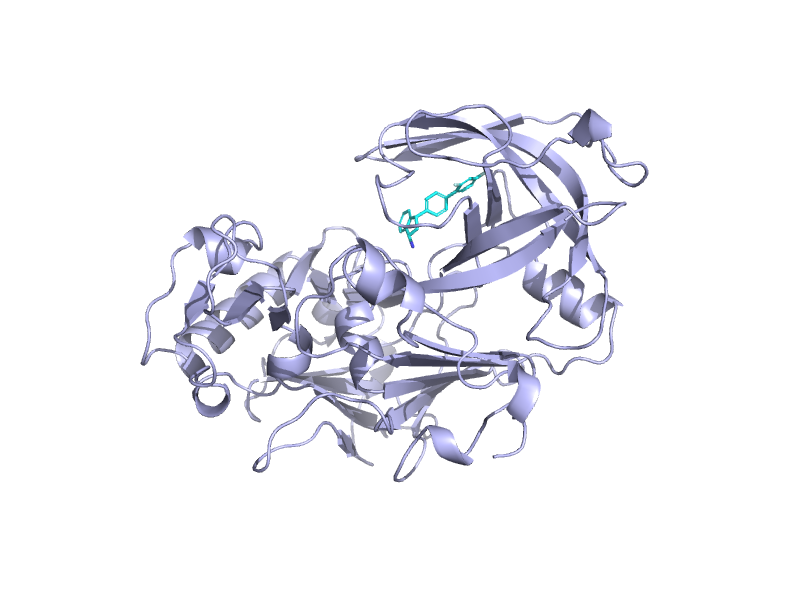

Local view of the boltz-generated P-L complex:


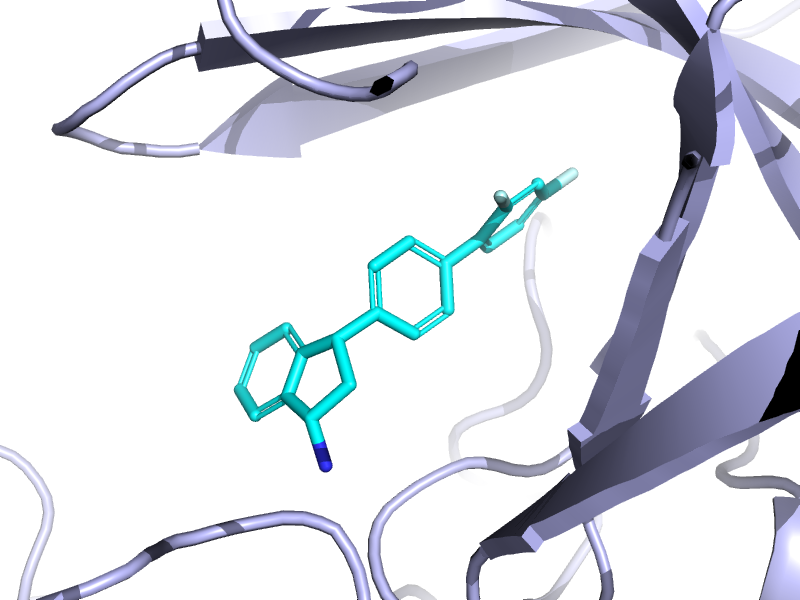

✓ already disconnected

✓ already disconnected



In [6]:
## Example 4. Performing protein-ligand docking using Boltz-2 and visualizing the resulting complex
from IPython.display import Image, display

async def main():
    tool_client = DrugSDAClient(DrugSDA_Tool_SERVER_URL)
    if not await tool_client.connect():
        print("connection failed")
        return
    
    model_client = DrugSDAClient(DrugSDA_Model_SERVER_URL)
    if not await model_client.connect():
        print("connection failed")
        return
    
    ## step 1. blotz-2 docking, call SCP tool boltz_binding_affinity
    sequence = 'GSFVEMVDNLRGKSGQGYYVEMTVGSPPQTLNILVDTGSSNFAVGAAPHPFLHRYYQRQLSSTYRDLRKGVYVPYTQGKWEGELGTDLVSIPHGPNVTVRANIAAITESDKFFINGSNWEGILGLAYAEIARPDDSLEPFFDSLVKQTHVPNLFSLQLCGAGFPLNQSEVLASVGGSMIIGGIDHSLYTGSLWYTPIRREWYYEVIIVRVEINGQDLKMDCKEYNYDKSIVDSGTTNLRLPKKVFEAAVKSIKAASSTEKFPDGFWLGEQLVCWQAGTTPWNIFPVISLYLMGEVTNQSFRITILPQQYLRPVEDVATSQDDCYKFAISQSSTGTVMGAVIMEGFYVVFDRARKRIGFAVSACHVHDEFRTAAVEGPFVTLDMEDCGYN'
    protein = [{'chain': 'A', 'sequence':sequence}]
    smiles_list = ['NC1CC(c2ccc(-c3ccc(F)cc3F)cc2)c2ccccc21']
    result = await model_client.session.call_tool(
        "boltz_binding_affinity",
        arguments={
            "protein": protein,
            "smiles_list": smiles_list
        }
    )
    
    result_data = model_client.parse_result(result)
    boltz_res = result_data["boltz_res"]
    print (boltz_res[0])
        
    ## step 2. Convert complex CIF to PDB, call SCP tool convert_complex_cif_to_pdb
    complex_cif = boltz_res[0]['cif_file']
    result = await tool_client.session.call_tool(
        "convert_complex_cif_to_pdb",
        arguments={
            "cif_file_path": complex_cif
        }
    )
    
    result_data = tool_client.parse_result(result)
    complex_pdb = result_data["output_file"]
    print (complex_pdb)
    
    ## step 3. Visualize P-L complex, call SCP tool visualize_complex
    result = await tool_client.session.call_tool(
        "visualize_complex",
        arguments={
            "pdb_file_path": complex_pdb
        }
    )
    
    result_data = tool_client.parse_result(result)
    full_view = result_data["global_image_path"]
    local_view = result_data["local_image_path"]
    # print (full_view, local_view)
    
    print ("Full view of the boltz-generated P-L complex:")
    display(Image(filename=full_view))
    
    print ("Local view of the boltz-generated P-L complex:")
    display(Image(filename=local_view))
    
    await model_client.disconnect()
    await tool_client.disconnect()
    
if __name__ == '__main__':
    await main()


In [7]:
## Example 5. Molecular similarity calculation and ranking

async def main():
    client = DrugSDAClient(DrugSDA_Tool_SERVER_URL)
    if not await client.connect():
        print("connection failed")
        return
    
    ## step 1. Calculate molecular similarity scores, call SCP tool calculate_smiles_similarity
    target = "CCO"  
    candidates = [
        "CCCO",      
        "CCCCO",     
        "CC(C)O",    
        "CCC(C)O",   
        "C1CC1",     
        "CC=O",      
        "CCCOO"      
    ]
    
    result = await client.session.call_tool(
        "calculate_smiles_similarity",
        arguments={
            "target_smiles": target,
            "candidate_smiles_list": candidates
        }
    )
    
    result_data = client.parse_result(result)
    similarities = result_data['similarities']
    # print (similarities)
    
    ## step 2. Select top 3 similar molecules
    top3_smiles = sorted(similarities, key=lambda x: x['score'], reverse=True)[:3]

    for item in top3_smiles:
        print(f"smiles: {item['smiles']}, score: {item['score']}")
    
    await client.disconnect()
    
if __name__ == '__main__':
    await main()

server url: https://scp.intern-ai.org.cn/api/v1/mcp/2/DrugSDA-Tool
✓ connect success
smiles: CCCO, score: 0.5
smiles: CCCCO, score: 0.3571
smiles: CCC(C)O, score: 0.3077
✓ already disconnected



server url: https://scp.intern-ai.org.cn/api/v1/mcp/2/DrugSDA-Tool
✓ connect success
[{'compound_name': 'aspirin', 'smiles': 'CC(=O)OC1=CC=CC=C1C(=O)O'}, {'compound_name': 'caffeine', 'smiles': 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'}]
Compound name: aspirin, SMILES: CC(=O)OC1=CC=CC=C1C(=O)O


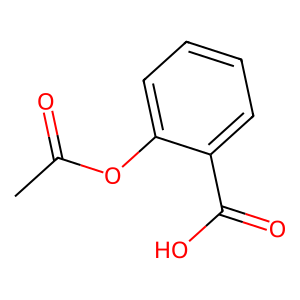

Compound name: caffeine, SMILES: CN1C=NC2=C1C(=O)N(C(=O)N2C)C


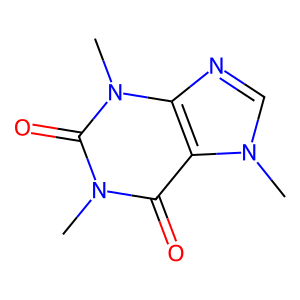

✓ already disconnected



In [8]:
## Example 6. Molecular retrieval and structural visualization
from IPython.display import Image, display

async def main():
    client = DrugSDAClient(DrugSDA_Tool_SERVER_URL)
    if not await client.connect():
        print("connection failed")
        return
    
    ## step 1. Fetch smiles by compound name, call SCP tool retrieve_smiles_by_compoundname
    compound_names = ["aspirin", "caffeine"]
    result = await client.session.call_tool(
        "retrieve_smiles_by_compoundname",
        arguments={
            "compound_names": compound_names
        }
    )
    
    result_data = client.parse_result(result)
    smiles_list = result_data["retrieve_smiles"]
    print (smiles_list)
    
    ## step 2. Visualize molecular structure, call SCP tool visualize_molecule
    for item in smiles_list:
        result = await client.session.call_tool(
            "visualize_molecule",
            arguments={
                "input": item["smiles"]
            }
        )
        
        result_data = client.parse_result(result)
        image_path = result_data['image_path']
        print ("Compound name: {}, SMILES: {}".format(item["compound_name"], item["smiles"]))
        display(Image(filename=image_path))
    
    await client.disconnect()
    
if __name__ == '__main__':
    await main()


In [9]:
## Example 7. Protein structure property analysis

async def main():
    client = DrugSDAClient(DrugSDA_Tool_SERVER_URL)
    if not await client.connect():
        print("connection failed")
        return
    
    ## step 1. Calculate PDB basic metrics, call SCP tool calculate_pdb_basic_info
    pdb_path = "/root/lwj/wll/code/DrugAgentTools/exp_data/6vkv_chainA_fix.pdb"
    result = await client.session.call_tool(
        "calculate_pdb_basic_info",
        arguments={
            "pdb_file_path": pdb_path
        }
    )
    
    result_data = client.parse_result(result)
    basic_metrics = result_data["metrics"]
    # print (basic_metrics)
    
    ## step 2. Calculate PDB structural geometry, call SCP tool calculate_pdb_structural_geometry
    result = await client.session.call_tool(
        "calculate_pdb_structural_geometry",
        arguments={
            "pdb_file_path": pdb_path
        }
    )
    
    result_data = client.parse_result(result)
    structure_metrics = result_data["metrics"]
    # print (structure_metrics)
    
    ## step 3. Calculate PDB quality metrics, call SCP tool calculate_pdb_quality_metrics
    result = await client.session.call_tool(
        "calculate_pdb_quality_metrics",
        arguments={
            "pdb_file_path": pdb_path
        }
    )
    
    result_data = client.parse_result(result)
    quality_metrics = result_data["metrics"]
    # print (quality_metrics)
    
    ## step 4. Calculate PDB composition info, call SCP tool calculate_pdb_composition_info
    result = await client.session.call_tool(
        "calculate_pdb_composition_info",
        arguments={
            "pdb_file_path": pdb_path
        }
    )
    
    result_data = client.parse_result(result)
    composition_metrics = result_data["metrics"]
    # print (composition_metrics)
    
    all_metrics = {**basic_metrics, **structure_metrics, **quality_metrics, **composition_metrics}
    for key, value in all_metrics.items():
        print(f"{key}: {value}")
    
    await client.disconnect()
    
if __name__ == '__main__':
    await main()

server url: https://scp.intern-ai.org.cn/api/v1/mcp/2/DrugSDA-Tool
✓ connect success
total_atoms: 3410
protein_atoms: 3410
het_atoms: 0
total_residues: 220
total_chains: 1
total_elements: 5
molecular_weight: 24340.042
chains: ['A']
elements: ['C', 'H', 'O', 'N', 'S']
x_range: 52.098
y_range: 46.067
z_range: 60.042
centroid: [9.1794, -66.7773, 0.5264]
radius_of_gyration: 22.7763
max_distance: 74.3593
avg_bfactor: 0.0
avg_occupancy: 1.0
avg_residues_per_chain: 220.0
atom_types: {'N': 220, 'H2': 1, 'H3': 1, 'CA': 220, 'HA': 205, 'C': 220, 'O': 220, 'CB': 205, 'HB2': 161, 'HB3': 161, 'CG': 129, 'HG2': 78, 'HG3': 78, 'CD': 68, 'HD2': 50, 'HD3': 37, 'H': 203, 'HB': 44, 'CG1': 28, 'HG12': 28, 'HG13': 28, 'CG2': 44, 'HG21': 44, 'HG22': 44, 'HG23': 44, 'CD1': 44, 'HD11': 32, 'HD12': 32, 'HD13': 32, 'HG11': 13, 'OE1': 31, 'NE2': 20, 'HE21': 15, 'HE22': 15, 'OD1': 17, 'ND2': 10, 'HD21': 27, 'HD22': 27, 'HG': 28, 'CD2': 34, 'HD23': 17, 'HA2': 15, 'HA3': 15, 'SD': 10, 'CE': 20, 'HE1': 27, 'HE2': 28

In [ ]:
## Example 8: Fluorescent protein retrieval and mutation prediction
from openai import OpenAI
import json

def call_llm_stream(prompt: str, system_prompt: str = "You are a helpful assistant") -> str:
    client = OpenAI(
        base_url="xxx",
        api_key="sk-xxx"
    )
    
    response = client.chat.completions.create(
        model="deepseek-reasoner",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": prompt}
        ],
        temperature=0.8
    )
    
    return response.choices[0].message.content

async def main(sequence):
    client = DrugSDAClient(DrugSDA_Model_SERVER_URL)
    if not await client.connect():
        print("connection failed")
        return
    
    ## step 2. Protein structure prediction, call SCP tool pred_protein_structure_esmfold
    result = await client.session.call_tool(
        "pred_protein_structure_esmfold",
        arguments={
            "sequence": sequence
        }
    )
    
    result_data = client.parse_result(result)
    print (result_data)
    pdb_path = result_data["pdb_path"]
    print ("protein structure: ", pdb_path)
    
    ## step 3. Mutant sequence prediction, call SCP tool pred_mutant_sequence
    result = await client.session.call_tool(
        "pred_mutant_sequence",
        arguments={
            "sequence": sequence,
            "pdb_file_path": pdb_path,
            "top_k": 10
        }
    )
    
    result_data = client.parse_result(result)
    for item in result_data["mutated_sequences"]:
        print (item)
    
    await client.disconnect()

if __name__ == '__main__':
    
    ## step 1. paper search for candidate fluorescent proteins, call LLM deepseek-reasoner
    prompt = "Task: The experiment aims to enhance the fluorescence intensity of eGFP through protein mutation. Please retrieve one candidate protein sequence that meets the following criteria."
    system_prompt = f"""Requirements:
1. Output only a list, with no additional content. Each element in the list must be in the format: {{"Name": "", "Mutated Amino Acid Sequence": "", "Reference": ""}}.
2. The cited reference must be a recently published English-language paper (must be real and from a journal with an impact factor greater than 10).
3. The mutated amino acid sequence provided must correspond to a real, experimentally validated variant."""
    response = call_llm_stream(prompt, system_prompt)
    protein_seq = json.loads(response)[0]["Mutated Amino Acid Sequence"]
    print ("protein sequence: ", protein_seq)
    
    await main(protein_seq)

protein sequence:  MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLTYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYITADKQKNGIKANFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITLGMDELYK
server url: https://scp.intern-ai.org.cn/api/v1/mcp/3/DrugSDA-Model
✓ connect success
{'status': 'success', 'msg': 'Protein structure saved successfully at exp_data/pdb_9406.pdb', 'pdb_path': '/root/lwj/wll/code/DrugAgentTools/exp_data/pdb_9406.pdb'}
protein structure:  /root/lwj/wll/code/DrugAgentTools/exp_data/pdb_9406.pdb
MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLTYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVVRIELKGIDFKEDGNILGHKLEYNYNSHNVYITADKQKNGIKANFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITLGMDELYK
MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLTYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDGGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYITADKQKNGIKANFKIRHNIEDGSV

In [14]:
## Example code for file transfer, implementing transmission of files between local and server sides using Base64 encoding.

async def main():
    client = DrugSDAClient(DrugSDA_Tool_SERVER_URL)
    if not await client.connect():
        print("connection failed")
        return
    
    ## step 1. convert server file to base64 string
    file_path = '/root/lwj/wll/code/DrugAgentTools/exp_data/6vkv.pdb'
    result = await client.session.call_tool(
        "server_file_to_base64",
        arguments={
            "file_path": file_path
        }
    )
    
    result_data = client.parse_result(result)
    file_name = result_data["file_name"]
    base64_string = result_data["base64_string"]
    print (file_name, base64_string[:20])
    
    ## step 2. convert base64 string to server file
    result = await client.session.call_tool(
        "base64_to_server_file",
        arguments={
            "file_name": file_name,
            "file_base64_string": base64_string
        }
    )
    
    result_data = client.parse_result(result)
    save_file = result_data['save_file']
    print (save_file)
    
    await client.disconnect()
    
if __name__ == '__main__':
    await main()

server url: https://scp.intern-ai.org.cn/api/v1/mcp/2/DrugSDA-Tool
✓ connect success
6vkv.pdb SEVBREVSICAgIFZJUkFM
/root/lwj/wll/code/DrugAgentTools/exp_data/6vkv_03651.pdb
✓ already disconnected

